In [24]:
# ============================================
# 6️ VALIDACIÓN Y EXPLICABILIDAD DEL MODELO
# ============================================

import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("CARGA DE DATOS Y MODELO")
print("="*70)

# Cargar datos limpios
df = pd.read_csv("data_no_outliers.csv")
print(f"Datos cargados: {len(df)} registros")

# Verificar si existe la columna Riesgo
if 'Riesgo' not in df.columns:
    print("\nColumna 'Riesgo' no encontrada. Recalculando...")
    
    # --- RECALCULAR PUNTAJE ---
    def calcular_puntaje(fila):
        """Calcula puntaje de riesgo basado en factores clínicos"""
        puntaje = 0
        
        def safe_value(value, default=0):
            return default if pd.isna(value) else int(value)
        
        # Edad
        edad_cat = safe_value(fila.get('Edad', 0))
        puntaje += [0, 5, 12, 20][min(edad_cat, 3)]
        
        # Antecedentes familiares
        puntaje += 25 if fila.get('FamiliarPrimerGradoCC', 0) == 1 else 0
        puntaje += 4 if fila.get('FamiliarSegundoGradoCC', 0) == 1 else 0
        
        # Diagnóstico previo
        puntaje += 30 if fila.get('DiagnosticoPrevioCancer', 0) == 1 else 0
        
        # Menstruación
        men_cat = safe_value(fila.get('Menstruacion', 1), 1)
        puntaje += [6, 3, 0][min(men_cat, 2)]
        
        # Primer embarazo
        hijo_cat = safe_value(fila.get('PrimerHijo', 1), 1)
        puntaje += [0, 5, 8][min(hijo_cat, 2)]
        
        # Ejercicio
        ej_cat = safe_value(fila.get('Ejercicio', 1), 1)
        puntaje += [5, 3, -2, -5][min(ej_cat, 3)]
        
        # Alcohol
        alc_cat = safe_value(fila.get('Alcohol', 1), 1)
        puntaje += [0, 2, 5, 8][min(alc_cat, 3)]
        
        # Mamografía
        puntaje += -3 if fila.get('Mamografia', 0) == 1 else 0
        
        return puntaje
    
    # Calcular puntaje
    df['Puntaje'] = df.apply(calcular_puntaje, axis=1)
    
    # Clasificar riesgo
    def clasificar_riesgo(puntaje):
        if puntaje < 20:
            return 0  # Bajo
        elif puntaje < 50:
            return 1  # Moderado
        else:
            return 2  # Alto
    
    df['Riesgo'] = df['Puntaje'].apply(clasificar_riesgo)
    
    print("Puntaje y Riesgo recalculados")
    
    # Guardar con la columna Riesgo
    df.to_csv("data_no_outliers.csv", index=False)
    print("Archivo actualizado con columna Riesgo")
else:
    print("Columna 'Riesgo' encontrada")

# Mostrar distribución de riesgo
print("\nDISTRIBUCIÓN DE RIESGO:")
for riesgo in sorted(df['Riesgo'].unique()):
    cantidad = (df['Riesgo'] == riesgo).sum()
    porcentaje = (cantidad / len(df)) * 100
    etiqueta = ['Bajo', 'Moderado', 'Alto'][riesgo]
    print(f"  Riesgo {riesgo} ({etiqueta}): {cantidad} ({porcentaje:.1f}%)")

# Cargar modelo
with open("modelo_random_forest.pkl", "rb") as f:
    modelo_rf = joblib.load(f)

print(f"\nModelo Random Forest cargado correctamente")
print(f"  Tipo: {type(modelo_rf)}")

print("\n" + "="*70)

CARGA DE DATOS Y MODELO
Datos cargados: 292 registros

Columna 'Riesgo' no encontrada. Recalculando...
Puntaje y Riesgo recalculados
Archivo actualizado con columna Riesgo

DISTRIBUCIÓN DE RIESGO:
  Riesgo 0 (Bajo): 27 (9.2%)
  Riesgo 1 (Moderado): 105 (36.0%)
  Riesgo 2 (Alto): 160 (54.8%)

Modelo Random Forest cargado correctamente
  Tipo: <class 'sklearn.ensemble._forest.RandomForestClassifier'>



In [25]:
# ============================================
# VERIFICACIÓN DE COLUMNAS
# ============================================

print("COLUMNAS DISPONIBLES EN EL DATASET")
print("="*70)

print("\nColumnas encontradas:")
for i, col in enumerate(df.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\n✓ Total de columnas: {len(df.columns)}")

COLUMNAS DISPONIBLES EN EL DATASET

Columnas encontradas:
   1. id_paciente
   2. nombre
   3. rut
   4. Edad
   5. fecha_registro
   6. id_medico
   7. FamiliarPrimerGradoCC
   8. FamiliarSegundoGradoCC
   9. DiagnosticoPrevioCancer
  10. Ejercicio
  11. Alcohol
  12. Mamografia
  13. Menstruacion
  14. PrimerHijo
  15. riesgo
  16. Edad_Original
  17. Puntaje
  18. Riesgo

✓ Total de columnas: 18


In [27]:
# ============================================
# PREPARACIÓN DE DATOS PARA EVALUACIÓN
# ============================================

print("PREPARACIÓN DE VARIABLES PARA EVALUACIÓN")
print("="*70)

# Columnas predictoras (las que usa el modelo)
columnas_predictoras = [
    'Edad', 'FamiliarPrimerGradoCC', 'FamiliarSegundoGradoCC',
    'DiagnosticoPrevioCancer', 'Menstruacion', 'PrimerHijo',
    'Ejercicio', 'Alcohol', 'Mamografia'
]

# Verificar que existan todas las columnas
columnas_faltantes = [c for c in columnas_predictoras if c not in df.columns]
if columnas_faltantes:
    print(f"ERROR: Columnas faltantes: {columnas_faltantes}")
    print("\nColumnas disponibles:")
    print(df.columns.tolist())
else:
    print("Todas las columnas predictoras están disponibles")

# Verificar que existe la columna objetivo
if 'Riesgo' not in df.columns:
    print("\nERROR CRÍTICO: Columna 'Riesgo' no encontrada")
    print("   Ejecute primero la Celda 1 que recalcula el Riesgo")
else:
    print("Columna objetivo 'Riesgo' encontrada")
    
    # Preparar X e y
    X = df[columnas_predictoras].copy()
    y = df['Riesgo'].copy()
    
    print(f"\nDimensiones de X (características): {X.shape}")
    print(f"Dimensiones de y (objetivo): {y.shape}")
    
    # Distribución del objetivo
    print("\nDISTRIBUCIÓN DEL OBJETIVO (Riesgo):")
    for clase in sorted(y.unique()):
        cantidad = (y == clase).sum()
        porcentaje = (cantidad / len(y)) * 100
        etiqueta = ['Bajo', 'Moderado', 'Alto'][int(clase)]
        print(f"  Clase {int(clase)} ({etiqueta}): {cantidad} ({porcentaje:.1f}%)")
    
    # Verificar valores nulos
    print("\nVERIFICACIÓN DE VALORES NULOS:")
    nulos_X = X.isnull().sum()
    if nulos_X.sum() > 0:
        print("Se encontraron valores nulos:")
        print(nulos_X[nulos_X > 0])
    else:
        print( "No hay valores nulos en X")
    
    print(f"Valores nulos en y: {y.isnull().sum()}")

print("\n" + "="*70)

PREPARACIÓN DE VARIABLES PARA EVALUACIÓN
Todas las columnas predictoras están disponibles
Columna objetivo 'Riesgo' encontrada

Dimensiones de X (características): (292, 9)
Dimensiones de y (objetivo): (292,)

DISTRIBUCIÓN DEL OBJETIVO (Riesgo):
  Clase 0 (Bajo): 27 (9.2%)
  Clase 1 (Moderado): 105 (36.0%)
  Clase 2 (Alto): 160 (54.8%)

VERIFICACIÓN DE VALORES NULOS:
Se encontraron valores nulos:
FamiliarPrimerGradoCC     16
Menstruacion             292
PrimerHijo                29
Alcohol                   19
dtype: int64
Valores nulos en y: 0



In [17]:
!pip install shap

In [28]:
# ============================================
# LIMPIEZA DE DATOS
# ============================================

print("LIMPIEZA Y PREPROCESAMIENTO FINAL")
print("="*70)

# Reemplazar infinitos por NaN
X = X.replace([np.inf, -np.inf], np.nan)

# Convertir a numérico
for col in X.columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Rellenar NaN con 0
X = X.fillna(0)

# Asegurar que y sea numérico
y = pd.to_numeric(y, errors='coerce')
y = y.fillna(y.mode()[0] if not y.mode().empty else 1)

print(f"Valores nulos en X después de limpieza: {X.isnull().sum().sum()}")
print(f"Valores nulos en y después de limpieza: {y.isnull().sum()}")

# --- PREDICCIÓN CON EL MODELO ---
print("\n" + "="*70)
print("REALIZANDO PREDICCIONES")
print("="*70)

try:
    # Verificar compatibilidad de columnas con el modelo
    if hasattr(modelo_rf, 'feature_names_in_'):
        print(f"\nColumnas esperadas por el modelo: {modelo_rf.n_features_in_}")
        print(f"Columnas proporcionadas: {X.shape[1]}")
        
        # Ajustar columnas si es necesario
        faltantes = [c for c in modelo_rf.feature_names_in_ if c not in X.columns]
        if faltantes:
            print(f"Columnas faltantes en X: {faltantes}")
            for col in faltantes:
                X[col] = 0
        
        # Reordenar columnas según el modelo
        X = X[modelo_rf.feature_names_in_]
    
    # Realizar predicción
    y_pred = modelo_rf.predict(X)
    
    print(f"Predicciones realizadas exitosamente")
    print(f"  Total de predicciones: {len(y_pred)}")
    print(f"  Predicciones únicas: {np.unique(y_pred)}")
    
except Exception as e:
    print(f"\nERROR al realizar predicciones: {str(e)}")
    raise

print("\n" + "="*70)

LIMPIEZA Y PREPROCESAMIENTO FINAL
Valores nulos en X después de limpieza: 0
Valores nulos en y después de limpieza: 0

REALIZANDO PREDICCIONES

Columnas esperadas por el modelo: 9
Columnas proporcionadas: 9
Predicciones realizadas exitosamente
  Total de predicciones: 292
  Predicciones únicas: [0 1 2]



MÉTRICAS DE EVALUACIÓN DEL MODELO

Accuracy: 0.9486 (94.86%)
F1-Score (macro): 0.9341

----------------------------------------------------------------------
REPORTE DE CLASIFICACIÓN
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Bajo     0.9231    0.8889    0.9057        27
    Moderado     0.9412    0.9143    0.9275       105
        Alto     0.9573    0.9812    0.9691       160

    accuracy                         0.9486       292
   macro avg     0.9405    0.9281    0.9341       292
weighted avg     0.9483    0.9486    0.9483       292

MATRIZ DE CONFUSIÓN
----------------------------------------------------------------------
[[ 24   3   0]
 [  2  96   7]
 [  0   3 157]]


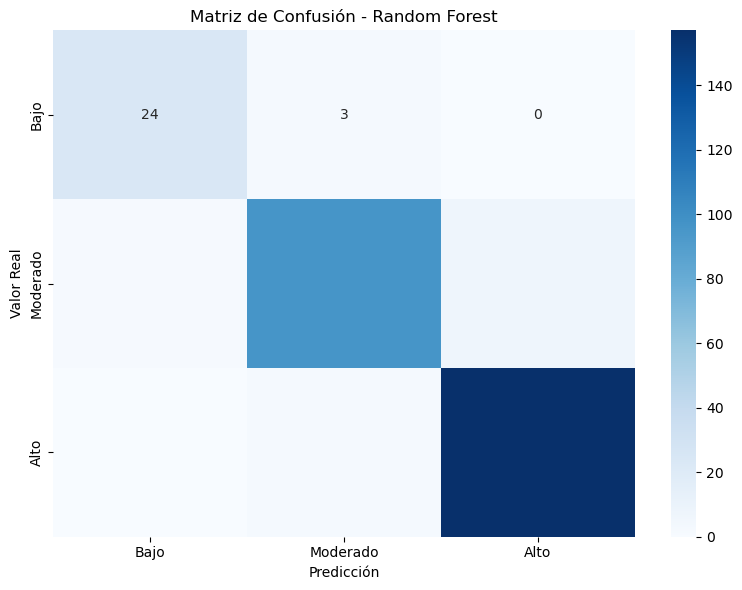


EVALUACIÓN COMPLETADA


In [29]:
# ============================================
# MÉTRICAS DE EVALUACIÓN
# ============================================

print("MÉTRICAS DE EVALUACIÓN DEL MODELO")
print("="*70)

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

# Accuracy
accuracy = accuracy_score(y, y_pred)
print(f"\nAccuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

# F1-Score
f1 = f1_score(y, y_pred, average='macro')
print(f"F1-Score (macro): {f1:.4f}")

# Reporte de clasificación
print("\n" + "-"*70)
print("REPORTE DE CLASIFICACIÓN")
print("-"*70)
print(classification_report(
    y, y_pred,
    target_names=['Bajo', 'Moderado', 'Alto'],
    digits=4
))

# Matriz de confusión
print("MATRIZ DE CONFUSIÓN")
print("-"*70)
cm = confusion_matrix(y, y_pred)
print(cm)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Bajo', 'Moderado', 'Alto'],
            yticklabels=['Bajo', 'Moderado', 'Alto'])
plt.title('Matriz de Confusión - Random Forest')
plt.ylabel('Valor Real')
plt.xlabel('Predicción')
plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("EVALUACIÓN COMPLETADA")
print("="*70)